## Libraries

In [2]:
#Lib import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt



## Data import and exploration

Instructions

Compute daily returns if not already done so

Perform a short exploratory analysis of your data. Discuss the expected values, covariances
and auto-covariances of your returns, How these characteristics change in time? 

In [5]:

# Define the directory containing your stock data
data_dir = r"C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\Data-ABE"

# Map file names to tickers for clarity
stock_files = {
    'GOOGL': 'Alphabet A Stock Price History.csv',
    'AMGN': 'Amgen Stock Price History.csv',
    'AVGO': 'Broadcom Stock Price History.csv',
    'DLTR': 'Dollar Tree Stock Price History.csv',
    'ISRG': 'Intuitive Surgical Stock Price History.csv',
    'LULU': 'Lululemon Athletica Stock Price History.csv',
    'QCOM': 'Qualcomm Stock Price History.csv',
    'TXN': 'Texas Instruments Stock Price History.csv',
}

risk_free_file = r'C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\USYields2024.csv'



In [10]:
# Function to calculate daily returns
def calculate_daily_returns(data):
    """
    Calculates daily returns as the logarithm of the ratio of Price to Open prices.
    """
    data['Daily_Return'] = np.log(data['Price'] / data['Open'])
    return data[['Date', 'Daily_Return']]

Loading data into one table and filter 1 Mo risk free rate with the Date


In [12]:
# Load and process stock data
daily_returns = {}
for ticker, file_name in stock_files.items():
    file_path = os.path.join(data_dir, file_name)
    print(f"Processing data for {ticker} from {file_path}...")
    data = pd.read_csv(file_path, parse_dates=['Date'])
    daily_returns[ticker] = calculate_daily_returns(data).set_index('Date')

# Combine daily returns into a single DataFrame
combined_returns = pd.concat(
    [df['Daily_Return'].rename(ticker) for ticker, df in daily_returns.items()],
    axis=1
)

Processing data for GOOGL from C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\Data-ABE\Alphabet A Stock Price History.csv...
Processing data for AMGN from C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\Data-ABE\Amgen Stock Price History.csv...
Processing data for AVGO from C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\Data-ABE\Broadcom Stock Price History.csv...
Processing data for DLTR from C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\Data-ABE\Dollar Tree Stock Price History.csv...
Processing data for ISRG from C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\Data-ABE\Intuitive Surgical Stock Price History.csv...
Processing data for LULU from C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\Data-ABE\Lululemon Athletica Stock Price History.csv...
Processing data for QCOM from C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\Data-ABE\Qualcomm Stock Price History.csv...
Processing data for TXN from C:

In [15]:
risk_free_rate = pd.read_csv(risk_free_file)

# Check the column names and ensure there are no extra spaces
print("\nColumn names:")
print(risk_free_rate.columns)

# Remove leading/trailing spaces from column names
risk_free_rate.columns = risk_free_rate.columns.str.strip()

# Check the first few rows to see the data structure
print("\nFirst few rows of the data:")
print(risk_free_rate.head())

# Ensure the '1 Mo' column is numeric and handle missing values
risk_free_rate['1 Mo'] = pd.to_numeric(risk_free_rate['1 Mo'], errors='coerce')

# Filter only the 'Date' and '1 Mo' columns
if 'Date' in risk_free_rate.columns:
    risk_free_rate = risk_free_rate[['Date', '1 Mo']].dropna()

    # Convert the annualized rate into a daily rate (assuming 252 trading days in a year)
    risk_free_rate['Daily_Risk_Free_Rate'] = (1 + risk_free_rate['1 Mo'] / 100) ** (1 / 252) - 1 #Is this neccesary???

    # Set the 'Date' column as the index for alignment with stock data
    risk_free_rate.set_index('Date', inplace=True)

    print("\nRisk-Free Rate Data (Head):")
    print(risk_free_rate.head())

    # Save the processed risk-free rate for later use
    risk_free_rate.to_csv('processed_risk_free_rate.csv')

    print("Risk-free rate processing complete. File saved as 'processed_risk_free_rate.csv'.")
else:
    print("The 'Date' column is missing or misnamed.")


Column names:
Index(['Date', '1 Mo', '2 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr',
       '7 Yr', '10 Yr', '20 Yr', '30 Yr'],
      dtype='object')

First few rows of the data:
         Date  1 Mo  2 Mo  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  \
0  02/01/2019  2.40  2.40  2.42  2.51  2.60  2.50  2.47  2.49  2.56   2.66   
1  03/01/2019  2.42  2.42  2.41  2.47  2.50  2.39  2.35  2.37  2.44   2.56   
2  04/01/2019  2.40  2.42  2.42  2.51  2.57  2.50  2.47  2.49  2.56   2.67   
3  07/01/2019  2.42  2.42  2.45  2.54  2.58  2.53  2.51  2.53  2.60   2.70   
4  08/01/2019  2.40  2.42  2.46  2.54  2.60  2.58  2.57  2.58  2.63   2.73   

   20 Yr  30 Yr  
0   2.83   2.97  
1   2.75   2.92  
2   2.83   2.98  
3   2.86   2.99  
4   2.88   3.00  

Risk-Free Rate Data (Head):
            1 Mo  Daily_Risk_Free_Rate
Date                                  
02/01/2019  2.40              0.000094
03/01/2019  2.42              0.000095
04/01/2019  2.40              0.000094
07/01/2019 

Performing exploratory analysis...

Expected Returns (Mean):
GOOGL    0.000631
AMGN    -0.000155
AVGO     0.000405
DLTR    -0.000027
ISRG     0.000066
LULU    -0.000661
QCOM    -0.000178
TXN     -0.000025
dtype: float64

Covariance Matrix:
          GOOGL      AMGN      AVGO      DLTR      ISRG      LULU      QCOM  \
GOOGL  0.000218  0.000029  0.000141  0.000048  0.000120  0.000128  0.000150   
AMGN   0.000029  0.000134  0.000039  0.000044  0.000044  0.000032  0.000036   
AVGO   0.000141  0.000039  0.000364  0.000066  0.000143  0.000161  0.000248   
DLTR   0.000048  0.000044  0.000066  0.000295  0.000058  0.000092  0.000068   
ISRG   0.000120  0.000044  0.000143  0.000058  0.000273  0.000142  0.000148   
LULU   0.000128  0.000032  0.000161  0.000092  0.000142  0.000353  0.000166   
QCOM   0.000150  0.000036  0.000248  0.000068  0.000148  0.000166  0.000359   
TXN    0.000105  0.000043  0.000173  0.000056  0.000101  0.000124  0.000189   

            TXN  
GOOGL  0.000105  
AMGN   0.000

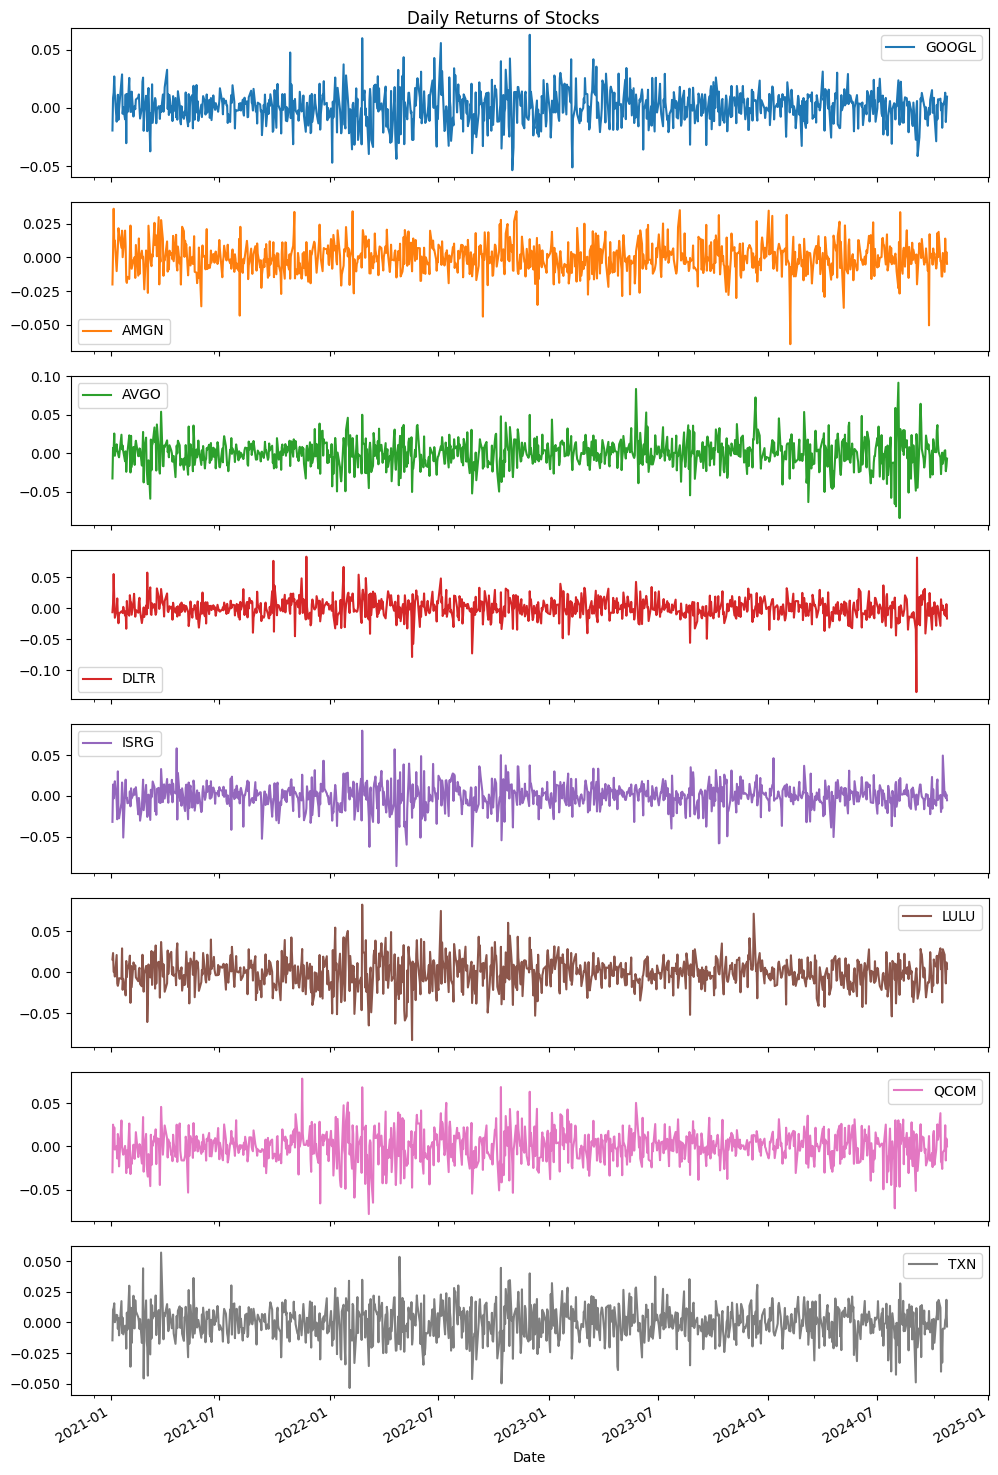


Risk-Free Rate Summary:
              1 Mo  Daily_Risk_Free_Rate
count  1457.000000           1457.000000
mean      2.362848              0.000092
std       2.197106              0.000085
min       0.000000              0.000000
25%       0.090000              0.000004
50%       2.060000              0.000081
75%       4.890000              0.000189
max       6.020000              0.000232
Data processing complete. Files saved as 'daily_returns.csv' and 'risk_free_rate.csv'.


In [16]:
# Exploratory analysis
print("Performing exploratory analysis...")
mean_returns = combined_returns.mean()
cov_matrix = combined_returns.cov()
auto_cov = combined_returns.apply(lambda col: col.autocorr())

print("\nExpected Returns (Mean):")
print(mean_returns)
print("\nCovariance Matrix:")
print(cov_matrix)
print("\nAuto-covariances (Autocorrelations):")
print(auto_cov)

# Plotting daily returns
combined_returns.plot(subplots=True, figsize=(10, 15), title='Daily Returns of Stocks')
plt.tight_layout()
plt.show()

# Summary of Risk-Free Rate
print("\nRisk-Free Rate Summary:")
print(risk_free_rate.describe())

# Save processed data for further analysis
combined_returns.to_csv('daily_returns.csv')
risk_free_rate.to_csv('risk_free_rate.csv')

print("Data processing complete. Files saved as 'daily_returns.csv' and 'risk_free_rate.csv'.")
